In [1]:
import iris
import matplotlib.pyplot as plt
import cartopy as cart
import numpy as np
import iris.analysis.cartography

In [2]:
import geopandas as gpd
import matplotlib.colors
import matplotlib.ticker

## Load data

In [3]:
npp_POD0_raw = iris.load('data/POD0/npp_M2018_POD0.nc')
npp_POD2 = iris.load('data/POD2/npp_M2018_POD2_daily.nc')
npp_control = iris.load('data/POD2/npp_control_POD2_daily.nc')

# I processed the new run differently
npp_POD0 = npp_POD0_raw[0].extract(iris.Constraint(longitude=npp_POD2[0].coord('longitude').points))

/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'npp' invalid units 'kgC m-2 s-1'
  warnings.warn(msg)
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'npp' invalid units 'kgC m-2 s-1'
  warnings.warn(msg)
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'npp' invalid units 'kgC m-2 s-1'
  warnings.warn(msg)


In [4]:
region_boundary= gpd.read_file("regions_shp/ne_10m_admin_1_states_provinces.shp")

In [5]:
#----------------------------------------------
# FUNCTION FOR NPP SUM
#---------------------------------------------

def npp(NPP_file):
    
    npp_total = NPP_file* 60 *60
    cumulative_npp = np.cumsum(npp_total.data, axis = 0)
    return cumulative_npp

## Calculate the NPP over a year

In [6]:
# GROUP BY YEAR (8760 hours)

year_groups_control = []
for i in range(0,43800,8760):
        yrs = npp_control[0][i:i+8760]
        year_groups_control.append(yrs)
        
year_groups_0 = []
for i in range(0,43800,8760):
        yrs = npp_POD0[i:i+8760]
        year_groups_0.append(yrs)
        
        
year_groups_2 = []
for i in range(0,43800,8760):
        yrs = npp_POD2[0][i:i+8760]
        year_groups_2.append(yrs)


In [7]:
# REDUCE LON DIMENSION 
lon_collapsed = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_control]
lon_collapsed_2 = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_2]
lon_collapsed_0 = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_0]

## mask nans in med data (from new processing method)
mask = np.ma.masked_invalid(lon_collapsed_0[0].data).mask
masked_0 = [iris.util.mask_cube(cube, mask) for cube in lon_collapsed_0]


In [8]:
# NPP SUM OVER EACH YEAR 

year_npp_control = []
for year in lon_collapsed:
    cumsum = npp(year)
    total = cumsum[-1]
    year_npp_control.append(total)


POD2_npp = []
for i, year in enumerate(lon_collapsed_2):
    cumsum = npp(year)
    total = cumsum[-1]
    POD2_npp.append(total)

POD0_npp = []
for i, year in enumerate(masked_0):
    cumsum = npp(year)
    total = cumsum[-1].T
    POD0_npp.append(total)

In [9]:
# average over the 5 years of the simulation

cont_avg = np.sum(year_npp_control, axis = 0)/5
POD0_avg = np.sum(POD0_npp, axis = 0)/5
POD2_avg = np.sum(POD2_npp, axis = 0)/5

## 1. Absolute loss

In [10]:
# Calculate loss per grid area

POD2_loss = cont_avg - POD2_avg
POD0_loss = cont_avg - POD0_avg

In [14]:
plt.rcParams.update({'font.size': 22})

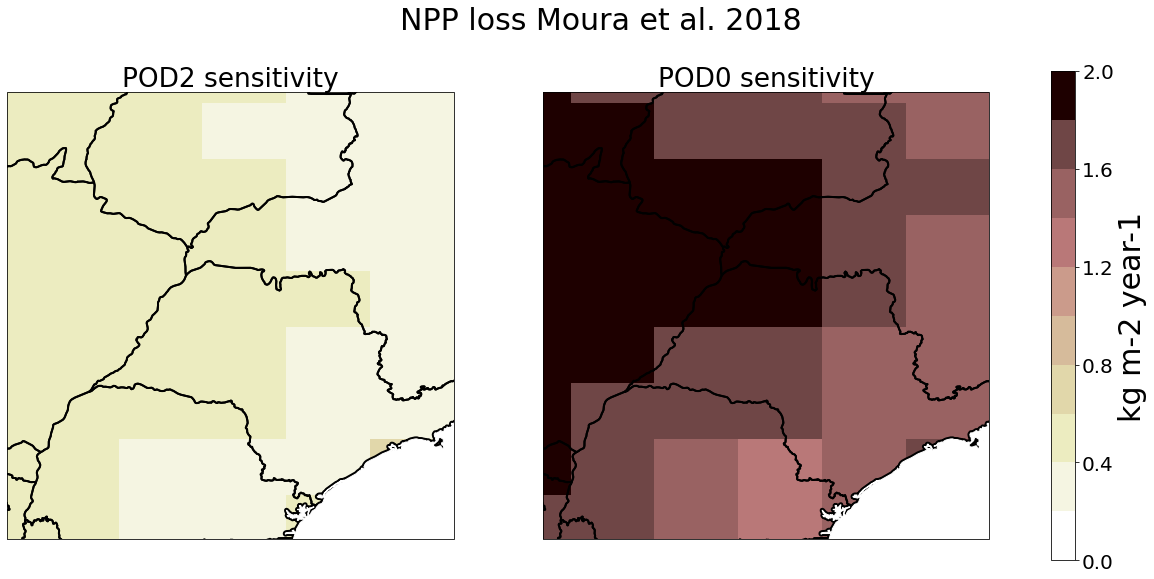

In [21]:

titles = [ 'POD2 sensitivity', 'POD0 sensitivity',]

fig, axs = plt.subplots(1,2, figsize = (22,9),  subplot_kw={'projection': cart.crs.PlateCarree()})

ax = axs.ravel()

y = lon_collapsed[0].coord('latitude').points
x = lon_collapsed[0].coord('longitude').points

levels = np.linspace(0,2,11)
cmap = plt.cm.pink_r
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
 
cf = ax[1].pcolormesh(x,y, POD0_loss.T, cmap = cmap, norm=norm)
cf = ax[0].pcolormesh(x,y, POD2_loss.T, cmap = cmap, norm=norm)

for i in range(0,2):
    ax[i].coastlines(linewidth=5)
    ax[i].add_feature(cart.feature.OCEAN, zorder=100,  facecolor = 'white')

    region_boundary.plot(ax = ax[i], edgecolor="black", facecolor="None", linewidth = 2)

    ax[i].set_xlim(-55,-45)
    ax[i].set_ylim(-26,-16)

    ax[i].set_title(titles[i])

fig.suptitle('NPP loss Moura et al. 2018', fontsize = 30)

cb = plt.colorbar(cf, ax = ax.tolist())
cb.ax.tick_params(labelsize = 20)
cb.set_label('kg m-2 year-1', size = 30)

## 2. Calculate yield loss

In [22]:
# Calculate loss per grid area

POD0_yield = POD0_avg*100 / cont_avg
POD2_yield = POD2_avg*100 / cont_avg

/tmp/ipykernel_6268/2726989016.py:3: RuntimeWarning: invalid value encountered in true_divide
  POD0_yield = POD0_avg*100 / cont_avg
/tmp/ipykernel_6268/2726989016.py:4: RuntimeWarning: invalid value encountered in true_divide
  POD2_yield = POD2_avg*100 / cont_avg


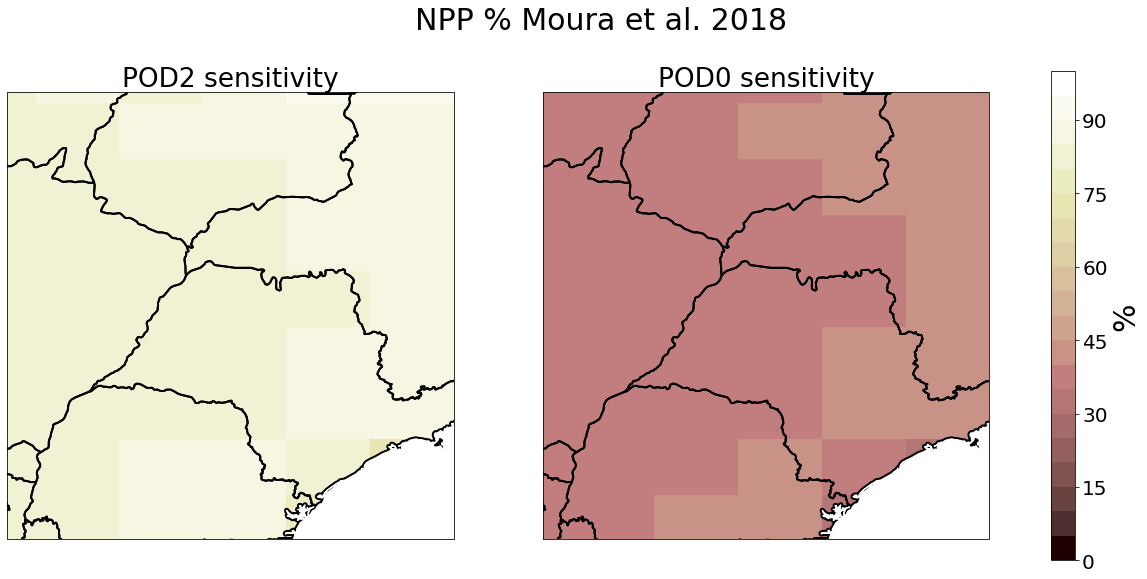

In [68]:
plt.rcParams.update({'font.size': 22})


fig, axs = plt.subplots(1,2, figsize = (22,9),  subplot_kw={'projection': cart.crs.PlateCarree()})

ax = axs.ravel()

y = lon_collapsed[0].coord('latitude').points
x = lon_collapsed[0].coord('longitude').points

levels = np.linspace(0,100,21)
cmap = plt.cm.pink
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
 
cf = ax[0].pcolormesh(x,y, POD2_yield.T, cmap = cmap, norm=norm)
cf = ax[1].pcolormesh(x,y, POD0_yield.T, cmap = cmap, norm=norm)

for i in range(0,2):
    ax[i].coastlines(linewidth=5)
    ax[i].add_feature(cart.feature.OCEAN, zorder=100,  facecolor = 'white')

    region_boundary.plot(ax = ax[i], edgecolor="black", facecolor="None", linewidth = 2)

    ax[i].set_xlim(-55,-45)
    ax[i].set_ylim(-26,-16)

    ax[i].set_title(titles[i])

fig.suptitle('NPP % Moura et al. 2018', fontsize = 30)

cb = plt.colorbar(cf, ax = ax.tolist())
cb.ax.tick_params(labelsize = 20)
cb.set_label('%', size = 30)

## 3. Calculate actual loss using frac

In [23]:
## import frac and make the same shape as dataset
frac = iris.load('/home/users/flossie/Sugarcane/data/frac4.nc')

frac_lat = frac[0][9].extract(iris.Constraint(latitude=lambda cell: -29 <= cell <=-15))
frac_lon = frac_lat.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321))
frac_sugarcane = frac_lon.data

In [25]:
# get grid areas in m
lon_collapsed_0[0].coord('latitude').units = 'degrees'
lon_collapsed_0[0].coord('longitude').units = 'degrees'

lon_collapsed_0[0].coord('latitude').guess_bounds()
lon_collapsed_0[0].coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(lon_collapsed_0[0][0], normalize=False)


In [26]:
# multiply by grid area to get total 

POD0_total = POD0_avg.T*grid_areas
POD2_total = POD2_avg.T*grid_areas
cont_total = cont_avg.T*grid_areas

In [27]:
# multiply by frac

POD0_frac = POD0_total*frac_sugarcane
POD2_frac = POD2_total*frac_sugarcane
cont_frac = cont_total*frac_sugarcane

In [28]:
# acutal loss

POD0_frac_loss = cont_frac - POD0_frac
POD2_frac_loss = cont_frac - POD2_frac


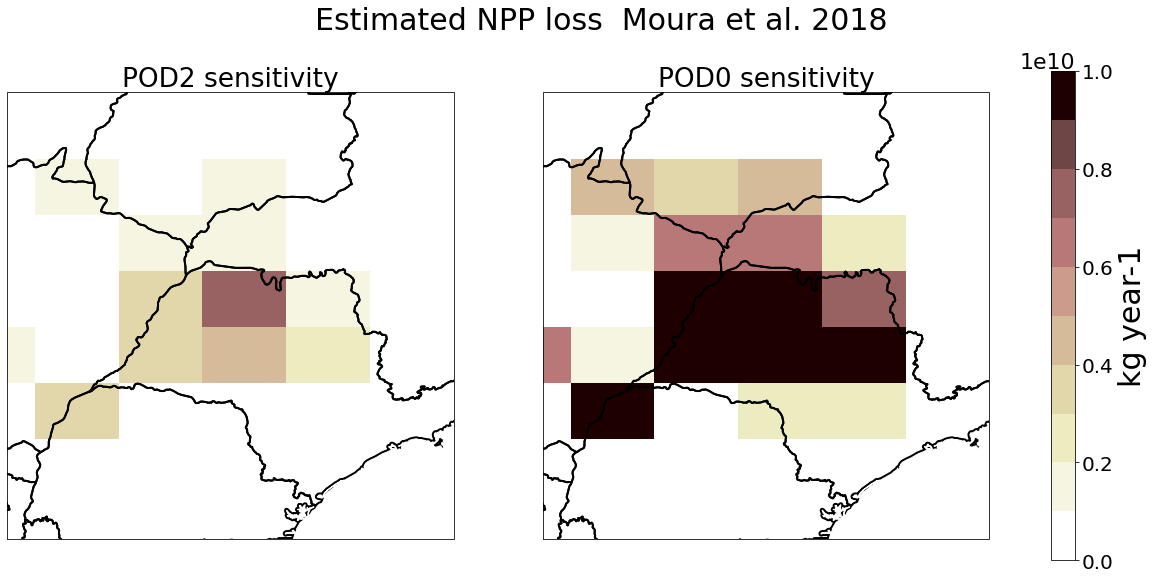

In [58]:

fig, axs = plt.subplots(1,2, figsize = (22,9),  subplot_kw={'projection': cart.crs.PlateCarree()})

ax = axs.ravel()

y = lon_collapsed[0].coord('latitude').points
x = lon_collapsed[0].coord('longitude').points

levels = np.linspace(0,10e9,11)
cmap = plt.cm.pink_r
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
 
cf = ax[1].pcolormesh(x,y, POD0_frac_loss, cmap = cmap, norm=norm)
cf = ax[0].pcolormesh(x,y, POD2_frac_loss, cmap = cmap, norm=norm)

for i in range(0,2):
    ax[i].coastlines(linewidth=5)
    ax[i].add_feature(cart.feature.OCEAN, zorder=100,  facecolor = 'white')

    region_boundary.plot(ax = ax[i], edgecolor="black", facecolor="None", linewidth = 2)

    ax[i].set_xlim(-55,-45)
    ax[i].set_ylim(-26,-16)

    ax[i].set_title(titles[i])

fig.suptitle('Estimated NPP loss  Moura et al. 2018', fontsize = 30)

cb = plt.colorbar(cf, ax = ax.tolist())
cb.ax.tick_params(labelsize = 20)
cb.set_label('kg year-1', size = 30)


## Total estimated NPP loss

In [29]:
#sum over area
areaav_control = np.nansum(cont_frac)*1e-9
areaav_0 = np.nansum(POD0_frac)*1e-9
areaav_2 = np.nansum(POD2_frac)*1e-9

Text(0.5, 1.0, 'Total sugarcane NPP and % biomass loss  Moura et al. 2018 ')

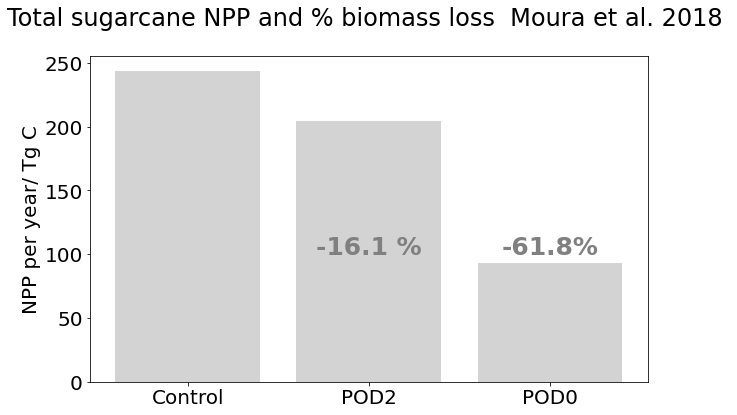

In [67]:
fig, ax = plt.subplots(figsize = (10,6))

plt.rcParams['font.size'] = '20'

ax.bar([0,1,2], [areaav_control, areaav_2, areaav_0 ], align='center', alpha=0.5, ecolor='black', capsize=10, facecolor = 'darkgrey')
ax.text(1, 100, '-16.1 %', horizontalalignment = 'center', fontsize = 25, fontweight = 'bold', color = 'grey')
ax.text(2, 100, '-61.8%', horizontalalignment = 'center', fontsize = 25, fontweight = 'bold', color = 'grey')
ax.set_ylabel('NPP per year/ Tg C')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Control','POD2', 'POD0'])
ax.set_title('Total sugarcane NPP and % biomass loss  Moura et al. 2018 ', pad = 30)

In [40]:
 1 - areaav_0/areaav_control
    #61.8% loss of productivity

0.6181522400091028

In [41]:
 1 - areaav_2/areaav_control
    #16% loss of productivity

0.1606499519148733